##  Part 1: Prepare Data

In [1]:
import sys
sys.path.append('E:\\git_folder\\quant_models')
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os

import random
import matplotlib.pylab as plt

In [2]:
N_ASSETS = 50 # 53
WINDOW_FIT = 50
WINDOW_HOLD = 10

In [3]:
import pandas as pd
from util.utils import get_daily_vol, sample_df, filter_df_time
data_fn = "././data/CNA_portfolio.csv"
df_pnl = pd.read_csv(data_fn)
test_df = df_pnl.copy()
test_df.rename(columns={'Date':'datetime'}, inplace=True)
test_df.loc[:,'datetime'] = pd.to_datetime(test_df.datetime)
test_df.set_index('datetime', inplace=True)
arr = np.arange(test_df.shape[1])
np.random.shuffle(arr)
cols_selected = arr[:N_ASSETS]
test_df = test_df.iloc[:,cols_selected]
print(test_df.head(2))

600585 SS T1440  601186 SS T1440  000338 SZ T1440  \
datetime                                                        
2012-01-05        12.121150         3.199641         5.200315   
2012-01-06        11.845547         3.173823         5.231768   

            600000 SS T1440  600104 SS T1440  000651 SZ T1440  \
datetime                                                        
2012-01-05         4.535425         9.543096         6.377904   
2012-01-06         4.549730         9.362336         6.197429   

            300142 SZ T1440  300003 SZ T1440  600606 SS T1440  \
datetime                                                        
2012-01-05         4.218003         6.119213         3.641050   
2012-01-06         4.109909         6.148420         3.538664   

            601288 SS T1440  ...  600900 SS T1440  002138 SZ T1440  \
datetime                     ...                                     
2012-01-05         1.724968  ...         4.688475         4.261747   
2012-01-06         

##  Part 2: Apply the portfolio adjusting method

In [14]:
from portfolio.optimize import HRPOpt, AutoencoderOpt

In [15]:
from portfolio.environment import EquityEnvironment

In [16]:
hrp_algo = HRPOpt(N_ASSETS, allow_short=False)
ae_algo  = AutoencoderOpt(N_ASSETS, allow_short=False)
env = EquityEnvironment(test_df)

In [17]:
used_agen = ae_algo

In [18]:
result_equal, result_agent   = [],  [] 
actions_equal, actions_agent = [], []
for i in range(WINDOW_FIT, len(test_df), WINDOW_HOLD):
    state, remove_cols = env.get_state(i, WINDOW_FIT, is_cov_matrix=False)
    action_equal = np.ones(N_ASSETS) / N_ASSETS
    action_hrp = used_agen.act(state, state.shape[1])
    state_action, _ = env.get_state(i+WINDOW_HOLD, WINDOW_HOLD, is_cov_matrix=False, is_fit=False)
    if remove_cols:
        action_equal = np.ones(state.shape[1]) / state.shape[1]
        state_action = state_action.loc[:, state.columns]
    r = np.dot(state_action, action_equal)
    result_equal.append(r.tolist())
    actions_equal.append(action_equal)
    r = np.dot(state_action, action_hrp)
    result_agent.append(r.tolist())
    actions_agent.append(action_hrp)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
remove the zero returns of stocks
{'300166 SZ T1440'}


ValueError: Error when checking input: expected input_51 to have shape (50,) but got array with shape (49,)

##  Part 3: Visualizing the Results of Portofolio

In [8]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_hrp_vis = [item for sublist in result_hrp for item in sublist]

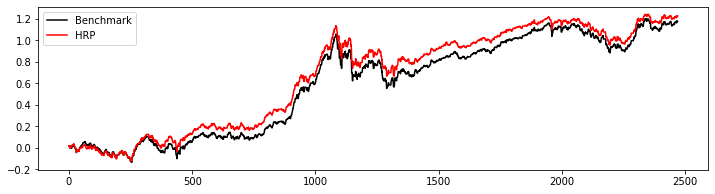

In [9]:
plt.figure(figsize = (12, 3))
plt.plot(np.array(result_equal_vis).cumsum(), label = 'Benchmark', color = 'black')
plt.plot(np.array(result_hrp_vis).cumsum(), label = 'HRP', color = 'red')
# plt.plot(np.array(result_smooth_vis).cumsum(), label = 'Forecasting', color = 'blue')
plt.legend()
plt.show()

In [10]:
from util.metrics import sharpe_iid
print(sharpe_iid(np.array(result_equal_vis), factor=255, log=False))
print(sharpe_iid(np.array(result_hrp_vis), factor=255, log=False))


0.6592959339892208
0.693447957168074


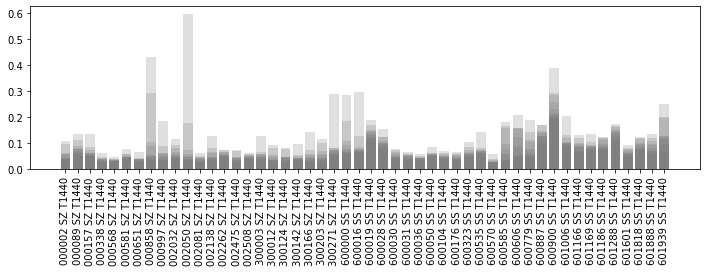

In [11]:
plt.figure(figsize = (12, 3))
for a in actions_hrp:
    asset_local = len(a)    
    plt.bar(np.arange(asset_local), a, color = 'grey', alpha = 0.25)
    plt.xticks(np.arange(asset_local), a.index, rotation='vertical')
plt.show()

In [12]:
actions_hrp[0].head()

000002 SZ T1440    0.012829
000089 SZ T1440    0.033327
000157 SZ T1440    0.005269
000338 SZ T1440    0.007932
000568 SZ T1440    0.008933
dtype: float64